<a href="https://colab.research.google.com/github/luohwu/RefreshingML/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#download the dataset 
%%shell
wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
unzip hymenoptera_data.zip

--2021-08-22 13:31:42--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 52.222.149.28, 52.222.149.79, 52.222.149.112, ...
Connecting to download.pytorch.org (download.pytorch.org)|52.222.149.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   102MB/s    in 0.4s    

2021-08-22 13:31:43 (102 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_dat

In [4]:
#make sure that the dataset is available
%%shell 
pwd 
ls

/content
hymenoptera_data  hymenoptera_data.zip	sample_data


In [5]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import  numpy as np
import  torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import  time
import  os
import  copy

#interactive mode
plt.ion()


In [6]:

#define transforms for trainning_data and test_data
data_transforms={
    'train':transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        ]
    ),
    'val':transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
    )
}

#create datasets
data_dir='hymenoptera_data'
image_datasets={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
                for x in ['train','val']}
dataLoaders={x: torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True,num_workers=4)
             for x in ['train','val']}

dataset_sizes={x: len(image_datasets[x]) for x in ['train','val']}
class_names=image_datasets['train'].classes

device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')


Using device cuda:0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:

#visualize the images
def imshow(inp,title=None):
    inp=inp.numpy().transpose((1,2,0))
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229,0.224,0.225])
    inp=inp*std+mean
    inp=np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(5.001)




In [8]:
# main function of training 
def train_model(model,criterion, optimizer, scheduler, num_epochs=25):
    since=time.time()
    best_model_wts=copy.deepcopy(model.state_dict())
    best_acc=0.0

    for epoch in range(num_epochs):
        print(f'epoch {epoch+1}/{num_epochs}\n')
        print('-'*20)

        for phase in ['train','val']:
            if phase=='train':
                model.train()
            else:
                model.eval()

            running_loss=0.0
            running_corrects=0

            #iterate over data
            for inputs, labels in dataLoaders[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)

                #zero gradients
                optimizer.zero_grad()

                #forward
                with torch.set_grad_enabled(phase=='train'):
                    outputs=model(inputs)
                    _,preds=torch.max(outputs,1)
                    loss=criterion(outputs,labels)

                    if phase=='train':
                        loss.backward()
                        optimizer.step()

                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==labels.data)

            if phase=='train':
                scheduler.step()

            #statistics
            epoch_loss=running_corrects/dataset_sizes[phase]
            epoch_acc=running_corrects.double()/dataset_sizes[phase]
            print(f'phase: {phase} loss:{epoch_loss}  acc:{epoch_acc}\n')

            if phase=='val' and epoch_acc>best_acc:
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())

    #training complete
    time_elapsed=time.time()-since
    print(f'training complete in {time_elapsed//60}m {time_elapsed%60}s \n')
    print(f'Best acc: {best_acc}')

    #return the model with best acc
    model.load_state_dict(best_model_wts)
    return  model



In [9]:
#visualizing the model

def visualize_model(model,num_images=6):
    was_training=model.training
    model.eval()
    images_so_far=0
    fig=plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataLoaders['val']):
            inputs=inputs.to(device)
            labels=labels.to(device)
            outputs=model(inputs)
            _,preds=torch.max(outputs,1)

            for j in range(inputs.size()[0]):
                images_so_far+=1
                ax=plt.subplot(num_images//2,2,images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted:{class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far==num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)




Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch 1/25

--------------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


phase: train loss:0.7745901346206665  acc:0.7745901639344263

phase: val loss:0.7647058963775635  acc:0.7647058823529412

epoch 2/25

--------------------
phase: train loss:0.8114753365516663  acc:0.8114754098360656

phase: val loss:0.8823529481887817  acc:0.8823529411764706

epoch 3/25

--------------------
phase: train loss:0.8114753365516663  acc:0.8114754098360656

phase: val loss:0.9084967374801636  acc:0.9084967320261438

epoch 4/25

--------------------
phase: train loss:0.799180269241333  acc:0.7991803278688525

phase: val loss:0.8888888955116272  acc:0.888888888888889

epoch 5/25

--------------------
phase: train loss:0.7704917788505554  acc:0.7704918032786886

phase: val loss:0.8169934749603271  acc:0.8169934640522876

epoch 6/25

--------------------
phase: train loss:0.8319671750068665  acc:0.8319672131147542

phase: val loss:0.8300653696060181  acc:0.8300653594771242

epoch 7/25

--------------------
phase: train loss:0.7663934230804443  acc:0.7663934426229508

phase: val

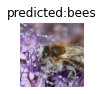

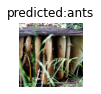

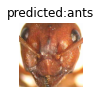

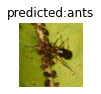

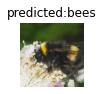

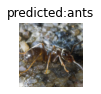

In [10]:

if __name__=='__main__':
    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 2)
    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()

    # all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
    visualize_model(model_ft)